<a href="https://colab.research.google.com/github/Konstantinosil/Tsioutsios-Linardatos-A-Factor-Augmented-Cointegration-Analysis-of-Shadow-and-Policy-Rates/blob/main/A_Factor_Augmented_Cointegration_Analysis_of_Shadow_and_Policy_Rates%2C_Tsioutsios_%26_Linardatos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get update -qq && apt-get install -y -qq r-base
!pip -q install rpy2

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
%load_ext rpy2.ipython

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/zoo_1.8-14.tar.gz'
Content type 'application/x-gzip' length 778426 bytes (760 KB)
downloaded 760 KB


The downloaded source packages are in
	‘/tmp/RtmpeVJ5by/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependencies ‘pracma’, ‘fracdist’

trying URL 'https://cloud.r-project.org/src/contrib/pracma_2.4.4.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/fracdist_0.1.1.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/FCVAR_0.1.4.tar.gz'

The downloaded source packages are in
	‘/tmp/RtmpeVJ5by/downloaded_packages’
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)
also installing the dependency ‘sandwich’

trying URL 'https://cloud.r-project.org/src/contrib/sandwich_3.1-1.tar.gz'
trying URL 'https://cloud.r-project.org/src/contrib/

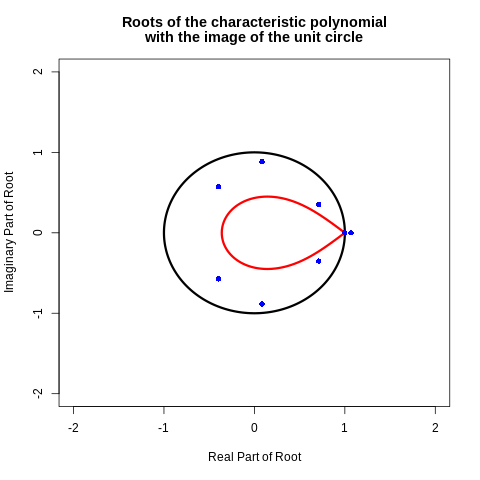

In [3]:
%%R

B_BOOT_MAIN <- 1999
B_BOOT_SIDE <-  999
H_LP        <-   24
LAGS_LP     <-   12
DO_PLOTS    <-  TRUE
set.seed(42)

req <- c("readxl","zoo","FCVAR","strucchange","vars","sandwich","lmtest","moments")
for (p in req) if (!requireNamespace(p, quietly=TRUE)) install.packages(p, repos="https://cloud.r-project.org")
suppressPackageStartupMessages({
  library(readxl); library(zoo)
  library(FCVAR); library(strucchange); library(vars)
  library(sandwich); library(lmtest); library(moments)
})

FILE <- "/content/data tsioutsios.xlsx"
SHEET_FFR <- "Policy Rate"; SHEET_SR <- "Shadow Rate"
OUTDIR <- "/content/fcvar_final_paper_silent"; dir.create(OUTDIR, showWarnings=FALSE, recursive=TRUE)

nullconn <- function(){ file(ifelse(.Platform$OS.type=="windows","NUL","/dev/null"), open="wt") }
quiet <- function(expr){
  zz <- nullconn(); zzm <- nullconn()
  on.exit({ try(sink(type="message")); try(sink()); try(close(zzm)); try(close(zz)) }, add=TRUE)
  sink(zz); sink(zzm, type="message")
  suppressWarnings(suppressMessages(force(expr)))
}
qcapture <- function(expr){ val <- NULL; quiet({ val <<- eval.parent(substitute(expr)) }); val }

toDate <- function(x){
  if (inherits(x,"Date")) return(as.Date(x))
  if (is.numeric(x)) { d <- try(as.Date(x, origin="1899-12-30"), silent=TRUE); if (!inherits(d,"try-error")) return(d) }
  s <- trimws(as.character(x))
  d <- suppressWarnings(as.Date(s, tryFormats=c(
    "%Y-%m-%d","%d/%m/%Y","%m/%d/%Y","%Y/%m/%d",
    "%Y.%m.%d","%d.%m.%Y","%m.%d.%Y","%b %Y","%B %Y","%Y-%m","%Y/%m")))
  i1 <- is.na(d) & grepl("^\\d{4}[-/]\\d{1,2}$", s); if (any(i1)) d[i1] <- as.Date(paste0(s[i1],"-01"))
  i2 <- is.na(d) & grepl("^\\d{4}[Mm]\\d{1,2}$", s)
  if (any(i2)) { yy <- substr(s[i2],1,4); mm <- substr(gsub("[^0-9]","",s[i2]),5,6); d[i2] <- as.Date(paste0(yy,"-",mm,"-01")) }
  d
}
read_two_col <- function(path, sheet){
  raw <- quiet(try(read_excel(path, sheet=sheet, col_names=TRUE), silent=TRUE))
  use_alt <- inherits(raw,"try-error") || ncol(raw)<2 || all(grepl("^\\.\\.\\.", names(raw)))
  df <- if (use_alt) {
    raw2 <- quiet(read_excel(path, sheet=sheet, col_names=FALSE)); stopifnot(nrow(raw2)>=2)
    hdr <- as.character(unlist(raw2[1,])); df<-raw2[-1,]; names(df)<-hdr; df
  } else raw
  nm <- tolower(names(df)); date_idx <- which(nm %in% c("date","time","period","month")); if (length(date_idx)==0) date_idx <- 1L
  value_idx <- setdiff(seq_len(ncol(df)), date_idx); stopifnot(length(value_idx)>=1); value_idx <- value_idx[1]
  out <- df[, c(date_idx,value_idx)]; names(out) <- c("Date", sheet)
  out$Date <- toDate(out$Date); out[[sheet]] <- suppressWarnings(as.numeric(out[[sheet]]))
  out <- out[complete.cases(out$Date) & !is.na(out[[sheet]]), ]; out <- out[order(out$Date), ]; rownames(out) <- NULL; out
}
ffr <- read_two_col(FILE, SHEET_FFR)
sr  <- read_two_col(FILE, SHEET_SR)
X   <- merge(ffr, sr, by="Date"); X <- X[order(X$Date),]; colnames(X) <- c("Date","FFR","SR")
Z   <- zoo(X[,c("FFR","SR")], order.by=X$Date); n <- nrow(Z)
writeLines(sprintf("Sample T=%d, span: %s–%s", n, index(Z)[1], index(Z)[n]),
           con=file.path(OUTDIR,"_run_header.txt"))

make_season_dums <- function(dates){
  mm <- as.integer(format(dates, "%m"))
  D <- model.matrix(~ factor(mm) - 1)
  colnames(D) <- paste0("M", sprintf("%02d", 1:12))
  D[,1:11, drop=FALSE]
}
SEAS <- make_season_dums(index(Z))

cosine_taper <- function(x, pct=0.1){
  n<-length(x); m<-floor(pct*n); if(m<=0) return(x-mean(x))
  w<-rep(1,n); t<-1:m; w[t]<-0.5*(1-cos(pi*t/(m+1))); w[(n-m+1):n]<-rev(w[1:m]); w*(x-mean(x))
}
periodogram <- function(x, taper=TRUE, pct=0.1){
  y<-if(taper) cosine_taper(x,pct) else (x-mean(x))
  n<-length(y); I<-(Mod(fft(y))^2)/(2*pi*n); j<-1:floor((n-1)/2); omega<-2*pi*j/n
  list(omega=omega, I=I[j+1])
}
gph_d <- function(x, delta=0.5, taper=TRUE){
  n<-length(x); m<-max(10,floor(n^delta)); pr<-periodogram(x,taper)
  om<-pr$omega[1:m]; Im<-pr$I[1:m]; y<-log(Im); X<-cbind(1,-2*log(2*sin(om/2)))
  b<-solve(t(X)%*%X,t(X)%*%y); d<-as.numeric(b[2])
  e<-y-X%*%b; XtXi<-solve(t(X)%*%X)
  cov<-XtXi %*% (t(X) %*% diag(as.numeric(e^2)) %*% X) %*% XtXi
  se<-sqrt(max(cov[2,2],0)); c(d=d,se=se,m=m)
}
lw_core <- function(x, delta=0.5, taper=TRUE, grid=c(-0.2,2.2), penalty=1e2){
  n<-length(x); m<-max(10,floor(n^delta))
  pr<-periodogram(x,taper); lam<-pr$omega[1:m]; Im<-pr$I[1:m]
  dgrid<-seq(grid[1], grid[2], length.out=800); loglam<-log(lam); Slog<-sum(loglam)
  Qbest<-Inf; dbest<-NA_real_
  for(d0 in dgrid){
    Q<-log(mean(Im*lam^(-2*d0))) + (2*d0/m)*Slog
    if (abs(d0-grid[1])<1e-8 || abs(d0-grid[2])<1e-8) Q <- Q + penalty
    if(Q<Qbest){ Qbest<-Q; dbest<-d0 }
  }
  se<-1/(2*sqrt(m)); se<-se*sqrt(1+m/n); c(d=dbest,se=se,m=m)
}
lw_adapt <- function(x, delta=0.5, taper=TRUE){
  g <- gph_d(x, delta, taper); g_d <- as.numeric(g["d"])
  s <- lw_core(x, delta, taper)
  d_raw <- as.numeric(s["d"]); m <- as.numeric(s["m"]); se <- as.numeric(s["se"])
  at_boundary <- isTRUE(d_raw <= -0.19) || isTRUE(d_raw >= 2.19)
  if (!is.na(g_d) && g_d>1 || at_boundary){
    xd <- diff(as.numeric(x)); if (length(xd) < 30) return(c(d=NA_real_, se=NA_real_, m=m))
    s2 <- lw_core(xd, delta, taper); d_fix <- 1 + as.numeric(s2["d"]); se_fix <- as.numeric(s2["se"])
    return(c(d=d_fix, se=se_fix, m=as.numeric(s2["m"])))
  }
  c(d=d_raw, se=se, m=m)
}
prewhite_ar <- function(x, p=1){
  x <- as.numeric(x) - mean(x)
  if (p<=0) return(x)
  fit <- quiet(try(stats::ar(x, order.max=p, aic=FALSE, method="yw"), silent=TRUE))
  if (inherits(fit,"try-error")) return(x)
  e <- as.numeric(filter(x, filter=fit$ar, method="recursive", sides=1)); e[is.na(e)] <- 0; e
}
DELTA <- c(0.45,0.5,0.6,0.7)
est_block <- function(x,name){
  do.call(rbind, lapply(DELTA, function(dlt){
    a<-gph_d(x,dlt,TRUE); b<-lw_adapt(x,dlt,TRUE)
    b_pw<-lw_adapt(prewhite_ar(x,1), dlt, TRUE)
    rbind(
      data.frame(var=name,method="GPH-tapered",delta=dlt,d=a["d"],se=a["se"],m=a["m"]),
      data.frame(var=name,method="LocalWhittle-adaptive",delta=dlt,d=b["d"],se=b["se"],m=b["m"]),
      data.frame(var=name,method="LW-adapt-PrewhiteAR1",delta=dlt,d=b_pw["d"],se=b_pw["se"],m=b_pw["m"])
    )
  }))
}
write.csv(rbind(est_block(coredata(Z[,"FFR"]),"FFR"),
                est_block(coredata(Z[,"SR"]),"SR")),
          file=file.path(OUTDIR,"persistence_semiparametric.csv"), row.names=FALSE)

dm_grid <- function(x, name, deltas=DELTA){
  n <- length(x); out <- list()
  for(dlt in deltas){
    mseq <- unique(pmax(10, floor(n^dlt) + (-20:20)))
    mseq <- mseq[mseq>9 & mseq < floor((n-1)/2)]
    vals <- lapply(mseq, function(m){ d_hat <- lw_core(x, dlt, TRUE)["d"]; c(m=m, d=as.numeric(d_hat)) })
    df <- as.data.frame(do.call(rbind, vals)); df$delta <- dlt; df$var <- name; out[[length(out)+1]] <- df
  }
  do.call(rbind, out)
}
write.csv(rbind(dm_grid(coredata(Z[,"FFR"]),"FFR"),
                dm_grid(coredata(Z[,"SR"]),"SR")),
          file=file.path(OUTDIR,"persistence_d_of_m.csv"), row.names=FALSE)

plugin_delta <- function(x, deltas=DELTA){
  n<-length(x); best<-list(score=Inf,delta=NA)
  for(dlt in deltas){
    e <- lw_adapt(x,dlt); mid<-floor(n/2)
    e1<-lw_adapt(x[1:mid],dlt); e2<-lw_adapt(x[(mid+1):n],dlt)
    stab <- (as.numeric(e1["d"])-as.numeric(e2["d"]))^2
    pen  <- 10/as.numeric(e["m"]); score<- stab + pen
    if(is.finite(score) && score<best$score) best<-list(score=score,delta=dlt)
  }
  best$delta
}
dlt_ffr <- plugin_delta(coredata(Z[,"FFR"]))
dlt_sr  <- plugin_delta(coredata(Z[,"SR"]))
FFR_LW    <- lw_adapt(coredata(Z[,"FFR"]), dlt_ffr)
SR_LW     <- lw_adapt(coredata(Z[,"SR"]),  dlt_sr)
FFR_LW_PW <- lw_adapt(prewhite_ar(coredata(Z[,"FFR"]),1), dlt_ffr)
SR_LW_PW  <- lw_adapt(prewhite_ar(coredata(Z[,"SR"]), 1), dlt_sr)

if (DO_PLOTS) quiet({
  png(file.path(OUTDIR,"periodogram_loglog.png"), width=1000, height=600)
  par(mfrow=c(1,2))
  for(v in c("FFR","SR")){
    x <- coredata(Z[,v]); pr <- periodogram(x, TRUE)
    plot(log(pr$omega), log(pr$I), main=paste("Log-Log Periodogram:",v), xlab="log(ω)", ylab="log(I(ω))")
    abline(lm(log(pr$I[1:floor(length(pr$I)*0.2)]) ~ log(pr$omega[1:floor(length(pr$omega)*0.2)])), lty=2)
  }
  dev.off()
  png(file.path(OUTDIR,"d_of_m_sensitivity.png"), width=1200, height=600)
  par(mfrow=c(1,2))
  D1 <- read.csv(file.path(OUTDIR,"persistence_d_of_m.csv"))
  with(subset(D1, var=="FFR"), plot(m,d,type="p", main="d(m) — FFR", xlab="m", ylab="d"))
  with(subset(D1, var=="SR"),  plot(m,d,type="p", main="d(m) — SR",  xlab="m", ylab="d"))
  dev.off()
})

get_p_safe <- function(X, lag.max=12, type="const", exogen=NULL, crit="AIC(n)", default=2L){
  obj <- qcapture(VARselect(X, lag.max=lag.max, type=type, exogen=exogen))
  p <- default
  if (!is.null(obj)) {
    sel <- try(obj$selection, silent=TRUE)
    if (!inherits(sel,"try-error") && !is.null(sel) && length(sel)>0) {
      if (crit %in% names(sel) && length(sel[[crit]])==1 && !is.na(sel[[crit]])) p <- as.integer(sel[[crit]])
    }
    if (!is.finite(p) || p < 1) {
      C <- NULL; if (!is.null(obj$criteria)) C <- obj$criteria
      if (!is.null(C) && nrow(C)>0) { cn <- if (crit %in% colnames(C)) crit else colnames(C)[1]; p <- which.min(C[, cn]) }
    }
  }
  p <- ifelse(is.finite(p) && p>=1, as.integer(p), as.integer(default)); p
}

fit_VAR_safe <- function(X, p, exogen=NULL){
  cand <- unique(pmax(1L, c(p, p-1L, p-2L, 1L)))
  for(pp in cand){
    vr <- quiet(try(VAR(X, p=pp, type="const", exogen=exogen), silent=TRUE))
    if(!inherits(vr,"try-error")){
      E <- try(residuals(vr), silent=TRUE)
      if(!inherits(E,"try-error") && !is.null(E)){
        E <- as.matrix(E); if(nrow(E)>0 && ncol(E)==ncol(X)) return(list(vr=vr, E=E, p=pp))
      }
    }
  }
  E <- scale(X, center=TRUE, scale=FALSE); E[is.na(E)] <- 0
  list(vr=NULL, E=as.matrix(E), p=1L)
}

wald_naive <- function(d1,se1,d2,se2){
  d1<-as.numeric(d1); se1<-as.numeric(se1); d2<-as.numeric(d2); se2<-as.numeric(se2)
  if(any(!is.finite(c(d1,se1,d2,se2)))||(se1^2+se2^2)<=0) return(c(W=NA_real_,p=NA_real_))
  W<-((d1-d2)^2)/(se1^2+se2^2); p<-1-pchisq(W,1); c(W=W,p=p)
}
sieve_boot <- function(x1,x2,B=999,delta1=NULL,delta2=NULL, crit="AIC(n)", exog=NULL){
  X <- cbind(FFR=as.numeric(scale(x1, FALSE)), SR=as.numeric(scale(x2, FALSE)))
  p0 <- get_p_safe(X, lag.max=12, type="const", exogen=exog, crit=crit, default=2L)
  fit <- fit_VAR_safe(X, p0, exog=exog)
  E <- fit$E; p <- fit$p; k <- ncol(X); Tn <- nrow(E)

  if (is.null(E) || !is.matrix(E) || nrow(E)<(p+1) || ncol(E)!=k){
    return(list(Wobs=NA_real_, Wb=rep(NA_real_,B), diff=rep(NA_real_,B),
                p=NA_real_, qW=rep(NA_real_,3), qDiff=rep(NA_real_,3),
                p_used=p0, B=B))
  }

  if (!is.null(fit$vr)) {
    Alist <- Acoef(fit$vr); A <- array(0, dim=c(k,k,p)); for(L in seq_len(p)) A[,,L] <- Alist[[L]]
    const <- sapply(fit$vr$varresult, function(eq){ cf<-coef(eq); if("const" %in% names(cf)) as.numeric(cf["const"]) else 0 })
  } else {
    A <- array(0, dim=c(k,k,p)); const <- rep(0, k)
  }

  d1 <- lw_adapt(X[,1], if(is.null(delta1)) 0.5 else delta1)
  d2 <- lw_adapt(X[,2], if(is.null(delta2)) 0.5 else delta2)
  se1 <- as.numeric(d1["se"]); se2 <- as.numeric(d2["se"])
  Wobs <- ((as.numeric(d1["d"]) - as.numeric(d2["d"]))^2) / (se1^2 + se2^2)

  Wb <- numeric(B); diffb <- numeric(B)
  for(b in seq_len(B)){
    sign <- sample(c(-1,1), size=Tn, replace=TRUE)
    Eb   <- sweep(E, 1, sign, "*")
    Y <- X[seq_len(max(1,p)),,drop=FALSE]
    for(t in (p+1):Tn){
      y <- const
      for(L in 1:p) y <- y + A[,,L] %*% Y[t-L,]
      y <- as.numeric(y) + Eb[t,]
      Y <- rbind(Y,y)
    }
    Ysim <- Y[(p+1):nrow(Y),,drop=FALSE]
    d1b <- lw_adapt(Ysim[,1], if(is.null(delta1)) 0.5 else delta1)
    d2b <- lw_adapt(Ysim[,2], if(is.null(delta2)) 0.5 else delta2)
    diffb[b] <- as.numeric(d1b["d"]) - as.numeric(d2b["d"])
    Wb[b] <- (diffb[b]^2) / (se1^2 + se2^2)
  }
  q  <- quantile(Wb,  c(.05,.5,.95), na.rm=TRUE)
  qd <- quantile(diffb,c(.025,.5,.975), na.rm=TRUE)
  list(Wobs=Wobs, Wb=Wb, diff=diffb,
       p=((sum(Wb >= Wobs, na.rm=TRUE))+1)/(sum(is.finite(Wb))+1),
       qW=q, qDiff=qd, p_used=p, B=B)
}
Wn <- wald_naive(FFR_LW["d"], FFR_LW["se"], SR_LW["d"], SR_LW["se"])
boot_runs <- list(
  AIC_999  = sieve_boot(coredata(Z[,"FFR"]), coredata(Z[,"SR"]), B=B_BOOT_SIDE, delta1=as.numeric(dlt_ffr), delta2=as.numeric(dlt_sr), crit="AIC(n)", exog=SEAS),
  SC_999   = sieve_boot(coredata(Z[,"FFR"]), coredata(Z[,"SR"]), B=B_BOOT_SIDE, delta1=as.numeric(dlt_ffr), delta2=as.numeric(dlt_sr), crit="SC(n)"),
  HQ_999   = sieve_boot(coredata(Z[,"FFR"]), coredata(Z[,"SR"]), B=B_BOOT_SIDE, delta1=as.numeric(dlt_ffr), delta2=as.numeric(dlt_sr), crit="HQ(n)"),
  AIC_1999 = sieve_boot(coredata(Z[,"FFR"]), coredata(Z[,"SR"]), B=B_BOOT_MAIN, delta1=as.numeric(dlt_ffr), delta2=as.numeric(dlt_sr), crit="AIC(n)")
)
for(nm in names(boot_runs)){
  br <- boot_runs[[nm]]
  write.csv(data.frame(Wb=br$Wb, diff=br$diff),
            file=file.path(OUTDIR, paste0("wald_boot_dist_", nm, ".csv")), row.names=FALSE)
}
wald_rows <- do.call(rbind, lapply(names(boot_runs), function(nm){
  br <- boot_runs[[nm]]
  data.frame(run=nm, p_used=br$p_used, B=br$B,
             Wobs=br$Wobs, p_boot=br$p,
             W_q05=br$qW[1], W_q50=br$qW[2], W_q95=br$qW[3],
             d_diff_q025=br$qDiff[1], d_diff_q50=br$qDiff[2], d_diff_q975=br$qDiff[3])
}))
write.csv(wald_rows, file=file.path(OUTDIR,"wald_boot_summary.csv"), row.names=FALSE)

kmax <- 6; orderWN <- 12
opt <- FCVARoptions(); opt$dbStep1D <- 0.05; opt$dbStep2D <- 0.05
opt$dbMin <- c(0.01,0.01); opt$dbMax <- c(2.0,2.0)
opt$constrained <- 0; opt$restrictDB <- 0; opt$progress <- 0; opt$gridSearch <- 0

x_raw <- as.matrix(coredata(Z))
x_mean <- apply(x_raw,2,mean,na.rm=TRUE); x_sd <- apply(x_raw,2,sd,na.rm=TRUE)
x <- scale(x_raw, center=x_mean, scale=x_sd)

scalar1 <- function(v){ if (is.null(v)) return(NA_real_); if (length(v) < 1) return(NA_real_); as.numeric(v[1]) }
grab <- function(expr_txt, env=list()){ tryCatch(eval(parse(text=expr_txt), envir=as.environment(env)), error=function(e) NULL) }
coalesce_num <- function(...) { xs <- list(...); for (z in xs) { if (!is.null(z)) { v <- as.numeric(z); if (length(v)>=1 && is.finite(v[1])) return(v[1]) } }; NA_real_ }
get_d_b_se <- function(m){
  d <- coalesce_num(grab("m$coeffs$dHat"), grab("m$coeffs$d"), grab("m$dHat"), grab("m$d"))
  b <- coalesce_num(grab("m$coeffs$bHat"), grab("m$coeffs$b"), grab("m$bHat"), grab("m$b"))
  if (is.na(d) || is.na(b)) {
    db_vec <- grab("m$coeffs$db"); if (is.null(db_vec)) db_vec <- grab("m$db")
    if (!is.null(db_vec) && length(db_vec)>=2) { if (is.na(d)) d <- as.numeric(db_vec[1]); if (is.na(b)) b <- as.numeric(db_vec[2]) }
  }
  se_d <- coalesce_num(grab("m$coeffs$StdErr$dHat"), grab("m$coeffs$StdErr$d"), grab("m$se$dHat"), grab("m$se$d"))
  se_b <- coalesce_num(grab("m$coeffs$StdErr$bHat"), grab("m$coeffs$StdErr$b"), grab("m$se$bHat"), grab("m$se$b"))
  list(d=d, b=b, se_d=se_d, se_b=se_b)
}
fcvar_lagselect_safe <- function(x, kmax, r, order, opt){
  obj <- quiet(try(FCVARlagSelect(x, kmax=kmax, r=r, order=order, opt=opt), silent=TRUE))
  if (!inherits(obj,"try-error")) return(obj)
  obj2 <- quiet(try(FCVARlagSelect(x, kmax=kmax, order=order, opt=opt), silent=TRUE))
  if (!inherits(obj2,"try-error")) return(obj2)
  NULL
}
get_k_from_lagSel <- function(lsel){
  if (is.null(lsel)) return(3L)
  ic <- NULL; if (!is.null(lsel$InformationCriteria)) ic <- lsel$InformationCriteria
  if (is.null(ic) && !is.null(lsel$IC)) ic <- lsel$IC
  if (is.null(ic)) return(3L)
  if (is.matrix(ic) || is.data.frame(ic)) { if ("AIC" %in% colnames(ic)) return(which.min(ic[,"AIC"])); return(which.min(ic[,1])) }
  else return(which.min(ic))
}
lagSel1 <- fcvar_lagselect_safe(x, kmax=kmax, r=1, order=orderWN, opt=opt); k1 <- get_k_from_lagSel(lagSel1)
rankTests <- quiet(FCVARrankTests(x, k1, opt))
get_r_hat_safe <- function(rt){
  if (!is.null(rt$r.hat.5.)) return(as.integer(rt$r.hat.5.))
  if (!is.null(rt$r.hat.10.)) return(as.integer(rt$r.hat.10.))
  if (!is.null(rt$r.hat)) return(as.integer(rt$r.hat))
  if (!is.null(rt$Table)) { nm <- colnames(rt$Table); cand <- nm[grepl("r\\.hat", nm)]; if (length(cand)>=1) { val <- suppressWarnings(as.integer(rt$Table[1, cand[1]])); if (length(val)==1 && is.finite(val)) return(val) } }
  1L
}
r_hat <- get_r_hat_safe(rankTests)
lagSel2 <- fcvar_lagselect_safe(x, kmax=kmax, r=r_hat, order=orderWN, opt=opt); k <- get_k_from_lagSel(lagSel2)

m_unres <- qcapture(FCVARestn(x, k, r_hat, opt))
MVWNtest_out <- if (!is.null(m_unres$Residuals)) quiet(MVWNtest(m_unres$Residuals, orderWN, TRUE)) else NULL
opt_db <- opt; opt_db$restrictDB <- 1
m_db <- qcapture(FCVARestn(x, k, r_hat, opt_db))
H_db <- if (!is.null(m_unres) && !is.null(m_db)) qcapture(FCVARhypoTest(m_unres, m_db)) else list(LR=NA, pVal=NA)

fc <- get_d_b_se(m_unres)
d_unres <- fc$d; b_unres <- fc$b; se_d <- fc$se_d; se_b <- fc$se_b
t_d <- ifelse(is.na(se_d) || se_d==0, NA_real_, d_unres/se_d)
t_b <- ifelse(is.na(se_b) || se_b==0, NA_real_, b_unres/se_b)
d_restr <- get_d_b_se(m_db)$d
LRval <- scalar1(H_db$LR)
PVval <- { pv1 <- scalar1(H_db$pVal); if (is.na(pv1)) scalar1(H_db$pval) else pv1 }

fcvar_LR_wild <- function(x, k, r, opt, B=B_BOOT_MAIN){
  set.seed(123)
  optq <- opt; optq$progress <- 0; opt0 <- optq; opt0$restrictDB <- 1
  m0 <- qcapture(FCVARestn(x, k, r, opt0))
  m1 <- qcapture(FCVARestn(x, k, r, optq))
  H  <- if(!is.null(m0) && !is.null(m1)) qcapture(FCVARhypoTest(m1, m0)) else list(LR=NA)
  LR_obs <- scalar1(H$LR)
  E0 <- if(!is.null(m0$Residuals)) as.matrix(m0$Residuals) else NULL
  if (is.null(E0) || nrow(E0)==0) return(list(LR_obs=LR_obs, p=NA_real_, LRb=rep(NA_real_, B)))
  Tn <- nrow(E0); LRb <- rep(NA_real_, B)
  for(b in 1:B){
    sgn <- sample(c(-1,1), size=Tn, replace=TRUE)
    Xb  <- x + sweep(E0, 1, sgn, "*")
    mb0 <- quiet(try(FCVARestn(Xb, k, r, opt0),      silent=TRUE))
    mb1 <- quiet(try(FCVARestn(Xb, k, r, optq), silent=TRUE))
    if(!inherits(mb0,"try-error") && !inherits(mb1,"try-error")){
      Hb <- quiet(try(FCVARhypoTest(mb1, mb0), silent=TRUE))
      if(!inherits(Hb,"try-error")) LRb[b] <- scalar1(Hb$LR)
    }
  }
  p <- ((sum(LRb >= LR_obs, na.rm=TRUE))+1)/(sum(is.finite(LRb))+1)
  list(LR_obs=LR_obs, p=p, LRb=LRb)
}
LRboot <- fcvar_LR_wild(x, k, r_hat, opt)
if (any(is.finite(LRboot$LRb))) write.csv(data.frame(LR_boot=LRboot$LRb), file=file.path(OUTDIR,"fcvar_LR_wild_boot.csv"), row.names=FALSE)

diag_out <- data.frame(
  JB_FFR = quiet(try({ if(!is.null(m_unres$Residuals)) { jb <- jarque.test(as.numeric(m_unres$Residuals[,1])); unname(jb$statistic) } else NA_real_ }, silent=TRUE)),
  JB_SR  = quiet(try({ if(!is.null(m_unres$Residuals)) { jb <- jarque.test(as.numeric(m_unres$Residuals[,2])); unname(jb$statistic) } else NA_real_ }, silent=TRUE)),
  SK_FFR = quiet(try(if(!is.null(m_unres$Residuals)) skewness(as.numeric(m_unres$Residuals[,1])) else NA_real_, silent=TRUE)),
  SK_SR  = quiet(try(if(!is.null(m_unres$Residuals)) skewness(as.numeric(m_unres$Residuals[,2])) else NA_real_, silent=TRUE)),
  KT_FFR = quiet(try(if(!is.null(m_unres$Residuals)) kurtosis(as.numeric(m_unres$Residuals[,1])) else NA_real_, silent=TRUE)),
  KT_SR  = quiet(try(if(!is.null(m_unres$Residuals)) kurtosis(as.numeric(m_unres$Residuals[,2])) else NA_real_, silent=TRUE))
)
write.csv(diag_out, file=file.path(OUTDIR,"fcvar_residual_diagnostics.csv"), row.names=FALSE)
if (!is.null(MVWNtest_out)) capture.output(MVWNtest_out, file=file.path(OUTDIR,"fcvar_mvwn_portmanteau.txt"))

Bhat <- try(as.matrix(m_unres$coeffs$betaHat), silent=TRUE)
Ahat <- try(as.matrix(m_unres$coeffs$alphaHat), silent=TRUE)
if (!inherits(Bhat,"try-error") && !is.null(Bhat)) { rownames(Bhat) <- c("FFR_std","SR_std"); write.csv(Bhat, file=file.path(OUTDIR,"fcvar_beta_fullsample.csv"), row.names=TRUE) }
if (!inherits(Ahat,"try-error") && !is.null(Ahat)) { rownames(Ahat) <- c("FFR_std","SR_std"); write.csv(Ahat, file=file.path(OUTDIR,"fcvar_alpha_fullsample.csv"), row.names=TRUE) }

start_obs <- max(120, 2*r_hat + 10)
BetaList <- list(); idx <- 1
for(i in seq(start_obs, nrow(x))){
  xi <- x[1:i,]; tmp <- quiet(try(FCVARestn(xi, k, r_hat, opt), silent=TRUE))
  if(!inherits(tmp,"try-error") && !is.null(tmp$coeffs$betaHat)){
    BetaList[[idx]] <- cbind(t_idx=i, tmp$coeffs$betaHat); idx <- idx + 1
  }
}
if(length(BetaList)>0){
  Bdf <- do.call(rbind, BetaList); dates <- index(Z)[Bdf[,"t_idx"]]
  Bdf <- data.frame(date=as.Date(dates), Bdf, row.names=NULL)
  write.csv(Bdf, file=file.path(OUTDIR,"fcvar_beta_recursive.csv"), row.names=FALSE)
}

quiet(try({
  bp_ffr <- breakpoints(coredata(Z[,"FFR"]) ~ 1)
  write.csv(data.frame(break_ffr_idx=breakdates(bp_ffr)), file=file.path(OUTDIR,"breaks_ffr.csv"), row.names=FALSE)
  sct_ffr <- sctest(coredata(Z[,"FFR"]) ~ 1, type="supF", vcov=NeweyWest)
  capture.output(sct_ffr, file=file.path(OUTDIR,"breaks_ffr_supF_HAC.txt"))
}, silent=TRUE))

get_ce <- function(m, xmat){
  if (is.null(m$Residuals) || is.null(m$coeffs$betaHat) || ncol(m$coeffs$betaHat)<1) return(NULL)
  beta <- m$coeffs$betaHat[,1,drop=FALSE]; as.numeric(xmat %*% beta)
}
ce <- quiet(try(get_ce(m_unres, x), silent=TRUE))
if(!inherits(ce,"try-error") && !is.null(ce)){
  quiet(try({
    bp_ce <- breakpoints(ce ~ 1)
    write.csv(data.frame(break_ce_idx=breakdates(bp_ce)), file=file.path(OUTDIR,"breaks_ce.csv"), row.names=FALSE)
    sct_ce <- sctest(ce ~ 1, type="supF", vcov=NeweyWest)
    capture.output(sct_ce, file=file.path(OUTDIR,"breaks_ce_supF_HAC.txt"))
  }, silent=TRUE))
}

lp <- function(y, x, H = H_LP, lags = LAGS_LP, bw_rule=function(h) max(4, floor(sqrt(h)))){
  out <- data.frame(h=integer(), beta=double(), se=double(), lo=double(), hi=double())
  yv <- as.numeric(y); xv <- as.numeric(x); Tn <- length(yv)
  for(h in 1:H){
    yf_full <- as.numeric(coredata(stats::lag(zoo(yv), -h))); yf <- yf_full[1:(Tn - h)]
    X0 <- xv[1:(Tn - h)]
    yl_full <- do.call(cbind, lapply(seq_len(lags), function(L) as.numeric(coredata(stats::lag(zoo(yv), L)))))
    xl_full <- do.call(cbind, lapply(seq_len(lags), function(L) as.numeric(coredata(stats::lag(zoo(xv), L)))))
    yl <- yl_full[1:(Tn - h), , drop = FALSE]; xl <- xl_full[1:(Tn - h), , drop = FALSE]
    Xmat <- cbind(X0 = X0, yl, xl, SEAS[1:(Tn - h),,drop=FALSE])
    df <- data.frame(y = yf, Xmat, check.names = FALSE); df <- df[stats::complete.cases(df), , drop = FALSE]
    if (nrow(df) < (lags + 10)) next
    colnames(df)[2] <- "shock"
    fit <- lm(y ~ . , data = df)
    bw <- bw_rule(h); V  <- sandwich::NeweyWest(fit, lag = bw, prewhite = FALSE, adjust = TRUE)
    b  <- unname(coef(fit)["shock"]); se <- sqrt(diag(V))["shock"]
    lo <- b - 1.96*se; hi <- b + 1.96*se
    out <- rbind(out, data.frame(h = h, beta = b, se = se, lo=lo, hi=hi))
  }
  out
}
write.csv(quiet(lp(Z[,"FFR"], Z[,"SR"])), file = file.path(OUTDIR, "lp_irf_ffr_on_sr.csv"), row.names = FALSE)
write.csv(quiet(lp(Z[,"SR"],  Z[,"FFR"])), file = file.path(OUTDIR, "lp_irf_sr_on_ffr.csv"),  row.names = FALSE)

Wb_main <- boot_runs$AIC_1999
write.csv(wald_rows, file=file.path(OUTDIR,"wald_boot_summary.csv"), row.names=FALSE)
write.csv(
  data.frame(
    T=n,
    FFR_d=FFR_LW["d"], FFR_se=FFR_LW["se"], FFR_d_PW=FFR_LW_PW["d"],
    SR_d =SR_LW["d"],  SR_se =SR_LW["se"],  SR_d_PW =SR_LW_PW["d"],
    Wald_naive_W=wald_naive(FFR_LW["d"],FFR_LW["se"],SR_LW["d"],SR_LW["se"])["W"],
    Wald_naive_p=wald_naive(FFR_LW["d"],FFR_LW["se"],SR_LW["d"],SR_LW["se"])["p"],
    Wald_boot_W=Wb_main$Wobs, Wald_boot_p=Wb_main$p,
    d_diff_CI_low=Wb_main$qDiff[1], d_diff_med=Wb_main$qDiff[2], d_diff_CI_high=Wb_main$qDiff[3],
    FCVAR_k=k, FCVAR_r=r_hat,
    FCVAR_d_unres=as.numeric(get_d_b_se(m_unres)$d),
    FCVAR_b_unres=as.numeric(get_d_b_se(m_unres)$b),
    FCVAR_d_restr=as.numeric(get_d_b_se(m_db)$d),
    FCVAR_LR_asym=as.numeric(LRval), FCVAR_p_asym=as.numeric(PVval),
    FCVAR_p_wild=as.numeric(LRboot$p)
  ),
  file=file.path(OUTDIR,"persistence_snapshot.csv"), row.names=FALSE
)
sink(file.path(OUTDIR,"session_info.txt")); print(sessionInfo()); sink()
saveRDS(list(
  B_BOOT_MAIN=B_BOOT_MAIN, B_BOOT_SIDE=B_BOOT_SIDE, H_LP=H_LP, LAGS_LP=LAGS_LP,
  DELTA=DELTA, FILE=FILE, SHEET_FFR=SHEET_FFR, SHEET_SR=SHEET_SR
), file=file.path(OUTDIR,"run_options_final.rds"))
